In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
import pyreadr

from utils import helpers

from importlib import reload

In [2]:
hits_data = pyreadr.read_r('hit_data.rds')[None]

outfield_dims = pyreadr.read_r('fences.rds')[None]

# From Geom

dims = pd.read_csv('https://raw.githubusercontent.com/bdilday/GeomMLBStadiums/master/inst/extdata/mlb_stadia_paths.csv')

In [3]:
# Get Correct Spray Angles

outfield_dims['spray_angle'] = outfield_dims.apply(lambda x: helpers.spray_angle(x.x, x.y),1) 

hits_data['spray_angle_true'] = hits_data.apply(lambda x: helpers.spray_angle(x.hc_x_, x.hc_y_),1)

In [4]:
outfield_dims['team_abv'] = outfield_dims['team'].apply(lambda x: helpers.mapping[x])

In [5]:
# For each ball hit, use the spline to interpolate the exact distance and height needed for a homerun at the designated park

def home_run_needed_metrics(spray_angle, team):
    temp = outfield_dims.query(f'team_abv == "{team}"').sort_values('spray_angle')

    dist_func = make_interp_spline(temp['spray_angle'], temp['d_wall'])
    height_func = make_interp_spline(temp['spray_angle'], temp['fence_height'],k=1)

    dist = dist_func(spray_angle)
    height = height_func(spray_angle)

    return dist, height


# Use physics to determine the height at the estimated distance. First step is if estimated dist >= dist at spray angle, next is if physics height 
# is >= height at spray angle

def is_home_run(hit_distance, launch_angle, hit_height, spray_angle, team):

    wall_distance, fence_height = home_run_needed_metrics(spray_angle, team)

    #Calculating V: initial velocity using estimated hit distance and launch angle
    velocity = np.sqrt(hit_distance/((np.sin(2*launch_angle*np.pi/180))/32.174))
    print(velocity)

    #Vox: Initial horizontal velocity using initial velocity and launch angle
    vox = np.cos(launch_angle/180*np.pi)*velocity
    print(vox)

    #Voy: Initial vertical velocity using initial velocity and launch angle
    voy = np.sin(launch_angle/180*np.pi)* velocity
    print(voy)
    
    #Time it takes to reach distance of mega field dimension
    time = wall_distance/vox
    print(time)

    #Calculating vertical height at distance of mega wall
    height_at_time = hit_height+(voy*time)+0.5*((-32.174)*(time**2))
    print(height_at_time)

    print(wall_distance)

    if height_at_time > fence_height:
        return 1
    else:
        return 0

# Analysis

In [6]:
def get_fence_height(launch_speed_fts, launch_angle_rads, plate_z, hit_distance_sc, spray_angle, team, g=-32.174):

    wall_distance, fence_height = home_run_needed_metrics(spray_angle, team)

    # calculate launch_speed_x and launch_speed_y
    launch_speed_x = launch_speed_fts * np.cos(launch_angle_rads)
    launch_speed_y = launch_speed_fts * np.sin(launch_angle_rads)
    
    # calculate total_time
    total_time = -(launch_speed_y + np.sqrt(launch_speed_y**2 + (2*g * plate_z))) / g
    
    # calculate acceleration_x
    acceleration_x = (-2*launch_speed_x / total_time) + (2*hit_distance_sc/total_time**2)
    
    # calculate time_wall
    time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
    
    # calculate height_at_wall
    height_at_wall = (launch_speed_y * time_wall) + (.5*g*(time_wall**2))
    
    # check if the ball clears the wall
    return fence_height

In [29]:
def is_home_run(launch_speed_fts, launch_angle_rads, plate_z, hit_distance_sc, spray_angle, team, g=-32.174):

    wall_distance, fence_height = home_run_needed_metrics(spray_angle, team)

    # calculate launch_speed_x and launch_speed_y
    launch_speed_x = launch_speed_fts * np.cos(launch_angle_rads)
    launch_speed_y = launch_speed_fts * np.sin(launch_angle_rads)
    
    # calculate total_time
    total_time = -(launch_speed_y + np.sqrt(launch_speed_y**2 + (2*g * plate_z))) / g
    
    # calculate acceleration_x
    acceleration_x = (-2*launch_speed_x / total_time) + (2*hit_distance_sc/total_time**2)
    
    # calculate time_wall
    time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
    
    # calculate height_at_wall
    height_at_wall = (launch_speed_y * time_wall) + (.5*g*(time_wall**2))
    
    # check if the ball clears the wall
    if height_at_wall > fence_height:
        return 1
    return 0

In [8]:
hits_data['is_homer'] = hits_data[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team']].apply(lambda x: is_home_run_dan(x[0],x[1],x[2],x[3],x[4],x[5]),1)

C:\Users\noahs\AppData\Local\Temp\ipykernel_26032\2449840775.py:16: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x


In [9]:
hits_data['fence_height'] = hits_data[['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team']].apply(lambda x: get_fence_height(x[0],x[1],x[2],x[3],x[4],x[5]),1)

C:\Users\noahs\AppData\Local\Temp\ipykernel_26032\2304299858.py:16: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x


In [10]:
def classifier(x):
    if x[0] == 'Home Run' and x[1] == 1:
        return 'Correct, Homer'
    elif x[0] == 'Home Run' and x[1] == 0:
        return 'Incorrect, Homer'
    elif x[0] != 'Home Run' and x[1] == 1:
        return 'Incorrect, Not Homer'
    elif x[0] != 'Home Run' and x[1] == 0:
        return 'Correct, Not Homer'

In [13]:
hits_data['class'].value_counts()

Correct, Not Homer      12277
Correct, Homer           3192
Incorrect, Homer          269
Incorrect, Not Homer      115
Name: class, dtype: int64

In [12]:
hits_data['class'] = hits_data[['events','is_homer']].apply(lambda x: classifier(x),1)

In [17]:
hits_data['height_diff'] = np.abs(hits_data['fence_height'] - hits_data['height_at_fence'])

In [ ]:
# Aaron Judge Season

In [26]:
aj = pd.read_csv('savant_data.csv')

In [27]:
aj = helpers.mlbam_xy_transformation(aj)

In [28]:
aj['spray_angle_true'] = aj.apply(lambda x: helpers.spray_angle(x.hc_x_, x.hc_y_),1)

In [34]:
def num_homers(launch_speed, launch_angle, plate_z, hit_distance_sc, spray_angle, g=-32.174):

    count = 0

    for team in hits_data['home_team'].unique():

        wall_distance, fence_height = home_run_needed_metrics(spray_angle, team)

        launch_speed_fts = launch_speed * 5280 / 3600

        launch_angle_rads = np.deg2rad(launch_angle)

        # calculate launch_speed_x and launch_speed_y
        launch_speed_x = launch_speed_fts * np.cos(launch_angle_rads)
        launch_speed_y = launch_speed_fts * np.sin(launch_angle_rads)
        
        # calculate total_time
        total_time = -(launch_speed_y + np.sqrt(launch_speed_y**2 + (2*g * plate_z))) / g
        
        # calculate acceleration_x
        acceleration_x = (-2*launch_speed_x / total_time) + (2*hit_distance_sc/total_time**2)
        
        # calculate time_wall
        time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
        
        # calculate height_at_wall
        height_at_wall = (launch_speed_y * time_wall) + (.5*g*(time_wall**2))
        
        # check if the ball clears the wall
        if height_at_wall > fence_height:
            count += 1

    return count

In [35]:
aj['num_homers'] = aj[['launch_speed','launch_angle','plate_z','hit_distance_sc','spray_angle_true']].apply(lambda x: num_homers(x[0],x[1],x[2],x[3],x[4]),1)

C:\Users\noahs\AppData\Local\Temp\ipykernel_26032\2862106138.py:24: RuntimeWarning: invalid value encountered in sqrt
  time_wall = (-launch_speed_x + np.sqrt(launch_speed_x**2 + 2*acceleration_x*wall_distance))/acceleration_x
C:\Users\noahs\AppData\Local\Temp\ipykernel_26032\2862106138.py:18: RuntimeWarning: invalid value encountered in sqrt
  total_time = -(launch_speed_y + np.sqrt(launch_speed_y**2 + (2*g * plate_z))) / g


In [42]:
aj.query('num_homers <= 7 and num_homers > 0')

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,hc_x_,hc_y_,spray_angle_true,num_homers
37,FF,2022-04-14,96.3,-2.07,5.75,"Judge, Aaron",592450,657240,double,hit_into_play,...,0,Infield shift,Strategic,208.0,0.017,0.594,-50.736991,430.378464,-6.723523,2
56,SI,2022-07-06,95.4,-1.95,6.01,"Judge, Aaron",592450,656605,double,hit_into_play,...,0,Standard,Standard,217.0,0.012,0.906,97.630650,375.249092,14.583639,3
68,FF,2022-07-27,95.2,-3.17,5.69,"Judge, Aaron",592450,453286,field_out,hit_into_play,...,0,Infield shift,Standard,223.0,0.015,-0.156,179.688312,294.264568,31.409709,1
73,FF,2022-07-30,95.0,-1.28,5.97,"Judge, Aaron",592450,669169,home_run,hit_into_play,...,0,Infield shift,Standard,211.0,0.135,1.911,175.196104,331.000845,27.891912,2
117,FF,2022-06-21,93.8,1.40,6.19,"Judge, Aaron",592450,621363,field_out,hit_into_play,...,5,Standard,Standard,175.0,0.035,-0.099,-174.222793,295.462490,-30.526207,2
126,FF,2022-04-16,93.4,-1.06,6.98,"Judge, Aaron",592450,669330,field_out,hit_into_play,...,0,Standard,Standard,197.0,0.034,-0.333,186.351754,306.069091,31.335362,7
144,FF,2022-04-13,92.9,-3.04,5.35,"Judge, Aaron",592450,621244,field_out,hit_into_play,...,3,Infield shift,Standard,220.0,-0.029,-0.284,84.478463,51.310996,58.726110,1
164,FF,2022-05-08,92.1,-1.80,6.04,"Judge, Aaron",592450,657248,field_out,hit_into_play,...,0,Infield shift,Standard,206.0,-0.033,-0.207,154.232468,117.396364,52.722877,3
193,FF,2022-06-29,90.5,1.44,6.07,"Judge, Aaron",592450,608344,field_out,hit_into_play,...,3,Standard,Standard,141.0,-0.006,-0.099,-173.024870,300.179308,-29.959366,2
206,SI,2022-06-14,89.7,-1.86,5.05,"Judge, Aaron",592450,446372,field_out,hit_into_play,...,0,Standard,Standard,220.0,-0.018,-0.184,-182.533377,264.216689,-34.638550,1


In [38]:
aj['num_homers'].value_counts()

0     321
30     39
1       6
2       5
29      5
9       3
15      3
22      3
28      3
3       2
18      2
27      2
10      1
4       1
23      1
7       1
20      1
16      1
24      1
Name: num_homers, dtype: int64

In [70]:
hits_data[hits_data['class']=='Incorrect, Not Homer']['home_team'].value_counts()

OAK    89
ARI    86
MIN    85
COL    81
ATL    77
WSH    75
SEA    74
BAL    73
BOS    72
SD     71
MIL    71
CIN    69
STL    58
TB     58
PHI    57
CWS    55
CLE    52
PIT    48
KC     48
HOU    47
LAA    47
TOR    45
TEX    45
NYM    44
CHC    44
LAD    43
SF     43
MIA    37
DET    36
NYY    24
Name: home_team, dtype: int64

In [19]:
hits_data[hits_data['class']=='Incorrect, Homer']['home_team'].value_counts()

NYY    33
TOR    30
LAD    19
SF     15
TEX    14
LAA    14
KC     12
MIA    12
CWS    12
CHC    11
TB     11
NYM     9
DET     9
HOU     8
CIN     7
CLE     6
OAK     5
MIN     5
BOS     5
BAL     5
SEA     5
PHI     4
WSH     4
PIT     3
ATL     3
STL     2
MIL     2
SD      2
COL     1
ARI     1
Name: home_team, dtype: int64

# Testing

In [20]:
hits_data[(hits_data['home_team']=='NYY') & (hits_data['class']=='Incorrect, Homer')][['launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','home_team']].head()

,launch_speed_fts,launch_angle_rads,plate_z,hit_distance_sc,spray_angle_true,home_team
392,148.133333,0.488692,2.28,359.0,25.584254,NYY
421,147.693333,0.488692,2.76,386.0,-25.096545,NYY
424,136.693333,0.645772,3.16,361.0,23.430489,NYY
538,151.653333,0.541052,2.70,396.0,14.821294,NYY
585,153.266667,0.366519,1.75,395.0,-24.426115,NYY


In [22]:
test_df = hits_data[(hits_data['home_team']=='NYY') & (hits_data['class']=='Incorrect, Homer')]

In [27]:
test_df[['player_name','game_date','inning','hc_x_','hc_y_','launch_speed_fts','launch_angle_rads','plate_z','hit_distance_sc','spray_angle_true','height_at_fence','away_team']].sort_values(['game_date','inning'])

,player_name,game_date,inning,hc_x_,hc_y_,launch_speed_fts,launch_angle_rads,plate_z,hit_distance_sc,spray_angle_true,height_at_fence,away_team
11518,Gary SÃ¡nchez,2021-04-03,4.0,-220.991667,294.389351,150.333333,0.401426,2.07,365.0,-36.894759,0.192957,TOR
11147,Rio Ruiz,2021-04-06,9.0,202.923009,281.661429,141.533333,0.750492,2.75,342.0,35.770868,-14.635553,BAL
10943,Anthony Santander,2021-04-07,4.0,81.982792,396.187771,160.893333,0.349066,2.92,401.0,11.691159,0.695614,BAL
12323,Francisco MejÃ­a,2021-04-17,2.0,152.884805,336.241754,148.573333,0.401426,3.06,365.0,24.450683,5.137936,TB
12274,Manuel Margot,2021-04-17,4.0,-80.310693,412.259892,157.520000,0.383972,2.52,416.0,-11.023499,-2.083826,TB
13277,Clint Frazier,2021-04-30,2.0,-226.681797,288.699221,156.493333,0.349066,3.04,364.0,-38.138410,2.978378,DET
15567,DJ LeMahieu,2021-05-07,1.0,182.558334,295.462490,142.413333,0.663225,2.48,343.0,31.710805,NaN,WSH
15520,Josh Bell,2021-05-07,2.0,40.255173,425.936170,161.773333,0.453786,3.33,423.0,5.398980,7.107050,WSH
8884,Gleyber Torres,2021-05-21,7.0,197.632186,288.599394,143.293333,0.506145,2.29,345.0,34.403251,1.950995,CWS
8325,Lourdes Gurriel Jr.,2021-05-25,4.0,97.905173,390.397815,155.320000,0.366519,1.97,398.0,14.078465,3.025422,TOR


In [37]:
outfield_dims.query('team_abv == "TOR"')

,stadium,full_team_name,team,team_abbr,x,y,d_wall,segment,spray_angle_stadia,fence_height,orientation,spray_angle,team_abv
130,Rogers Centre,Toronto Blue Jays,blue_jays,TOR,-233.110166,243.793399,337.306346,outfield_outer,-32.8,8.0,NNW,-43.716718,TOR
131,Rogers Centre,Toronto Blue Jays,blue_jays,TOR,-224.350053,256.728774,340.943705,outfield_outer,-30.9,8.0,NNW,-41.149549,TOR
132,Rogers Centre,Toronto Blue Jays,blue_jays,TOR,-215.386659,269.526873,345.016156,outfield_outer,-29.0,8.0,NNW,-38.629355,TOR
133,Rogers Centre,Toronto Blue Jays,blue_jays,TOR,-206.412251,282.317339,349.727175,outfield_outer,-27.1,8.0,NNW,-36.171866,TOR
134,Rogers Centre,Toronto Blue Jays,blue_jays,TOR,-197.476374,295.135246,355.108056,outfield_outer,-25.3,8.0,NNW,-33.786666,TOR
135,Rogers Centre,Toronto Blue Jays,blue_jays,TOR,-188.557911,307.965270,361.104823,outfield_outer,-23.6,8.0,NNW,-31.477887,TOR
136,Rogers Centre,Toronto Blue Jays,blue_jays,TOR,-179.662122,320.810969,367.693019,outfield_outer,-21.9,8.0,NNW,-29.249911,TOR
137,Rogers Centre,Toronto Blue Jays,blue_jays,TOR,-170.823557,333.695531,374.877840,outfield_outer,-20.3,8.0,NNW,-27.108562,TOR
138,Rogers Centre,Toronto Blue Jays,blue_jays,TOR,-160.959444,345.726231,381.358846,outfield_outer,-18.7,8.0,NNW,-24.965231,TOR
139,Rogers Centre,Toronto Blue Jays,blue_jays,TOR,-148.337786,354.910001,384.662460,outfield_outer,-17.0,8.0,NNW,-22.682922,TOR


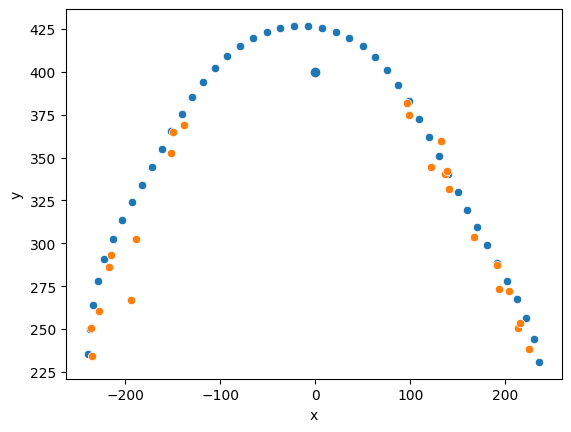

In [74]:
sns.scatterplot(outfield_dims.query('team_abv == "NYY"'),x='x',y='y',)
sns.scatterplot(hits_data[(hits_data['home_team']=='NYY') & (hits_data['class']=='Incorrect, Not Homer')], x='hc_x_',y='hc_y_')
plt.plot(0,400,'o')

In [ ]:
# transformation from current inflated points to new points based on like 5 existing datapoints.
# essentially shrink the spline

In [62]:
dist_func(0) - 408

18.25974394179059

In [63]:
dist_func(45) - 314

17.641525144702996

In [64]:
dist_func(-45) - 318

20.115345948048002

In [76]:
hits_data.columns

Index(['player_name', 'game_date', 'game_type', 'player_team', 'events', 'des',
       'home_team', 'away_team', 'bb_type', 'outs_when_up', 'inning',
       'inning_topbot', 'plate_z', 'hc_x', 'hc_y', 'hit_distance_sc',
       'launch_angle', 'launch_speed', 'hc_x_', 'hc_y_', 'launch_angle_rads',
       'launch_speed_fts', 'launch_speed_x', 'launch_speed_y', 'spray_angle',
       'index', 'hit_direction', 'stadium_observed', 'logo_html', 'headshot',
       'spray_angle_true', 'is_homer', 'height_at_fence', 'class',
       'fence_height', 'height_diff'],
      dtype='object')

In [79]:
hits_data[(hits_data['class']=='Incorrect, Not Homer') & (hits_data['home_team']=='NYY')]

,player_name,game_date,game_type,player_team,events,des,home_team,away_team,bb_type,outs_when_up,...,hit_direction,stadium_observed,logo_html,headshot,spray_angle_true,is_homer,height_at_fence,class,fence_height,height_diff
455,Ronald Torreyes,2021-07-20,R,PHI,Double,Ronald Torreyes doubles (8) on a line drive to...,NYY,PHI,line_drive,2.0,...,Left,Yankee Stadium,<img src = 'https://a.espncdn.com/i/teamlogos/...,NaN,-35.983125,1,4.589938,"Incorrect, Not Homer",8.0,3.410062
779,Christian VÃ¡zquez,2021-07-18,R,BOS,Double,Christian Vazquez doubles (14) on a fly ball t...,NYY,BOS,fly_ball,1.0,...,Right,Yankee Stadium,<img src = 'https://a.espncdn.com/i/teamlogos/...,NaN,36.886721,1,-7.373832,"Incorrect, Not Homer",8.0,15.373832
964,Enrique HernÃ¡ndez,2021-07-17,R,BOS,"In play, out(s)",Enrique Hernandez flies out to right fielder T...,NYY,BOS,fly_ball,2.0,...,Right-Center,Yankee Stadium,<img src = 'https://a.espncdn.com/i/teamlogos/...,NaN,21.867275,1,-7.036727,"Incorrect, Not Homer",8.0,15.036727
1196,Christian Arroyo,2021-07-16,R,BOS,"In play, out(s)",Christian Arroyo flies out to right fielder Ho...,NYY,BOS,fly_ball,2.0,...,Right,Yankee Stadium,<img src = 'https://a.espncdn.com/i/teamlogos/...,NaN,43.376792,1,-38.076643,"Incorrect, Not Homer",8.0,46.076643
1204,Gleyber Torres,2021-07-16,R,NYY,"In play, out(s)",Gleyber Torres flies out to right fielder Hunt...,NYY,BOS,fly_ball,0.0,...,Right,Yankee Stadium,<img src = 'https://a.espncdn.com/i/teamlogos/...,NaN,40.420321,1,NaN,"Incorrect, Not Homer",8.0,NaN
2482,Gio Urshela,2021-07-03,R,NYY,"In play, out(s)",Gio Urshela flies out to right fielder Michael...,NYY,NYM,fly_ball,0.0,...,Right,Yankee Stadium,<img src = 'https://a.espncdn.com/i/teamlogos/...,NaN,28.805187,1,NaN,"Incorrect, Not Homer",7.999999999999999,NaN
3242,Anthony Rendon,2021-06-28,R,LAA,Double,Anthony Rendon doubles (11) on a sharp fly bal...,NYY,LAA,fly_ball,1.0,...,Right-Center,Yankee Stadium,<img src = 'https://a.espncdn.com/i/teamlogos/...,NaN,14.788621,1,-8.512675,"Incorrect, Not Homer",8.0,16.512675
3893,Hanser Alberto,2021-06-24,R,KC,Double,Hanser Alberto doubles (11) on a fly ball to l...,NYY,KC,fly_ball,0.0,...,Left,Yankee Stadium,<img src = 'https://a.espncdn.com/i/teamlogos/...,NaN,-41.243827,1,-20.693216,"Incorrect, Not Homer",8.0,28.693216
3968,Whit Merrifield,2021-06-23,R,KC,"In play, out(s)",Whit Merrifield flies out to center fielder Aa...,NYY,KC,fly_ball,1.0,...,Right-Center,Yankee Stadium,<img src = 'https://a.espncdn.com/i/teamlogos/...,NaN,20.234434,1,-6.078955,"Incorrect, Not Homer",8.0,14.078955
4045,Luke Voit,2021-06-23,R,NYY,Single,Luke Voit singles on a fly ball to left fielde...,NYY,KC,fly_ball,1.0,...,Left,Yankee Stadium,<img src = 'https://a.espncdn.com/i/teamlogos/...,NaN,-31.971832,1,-4.068711,"Incorrect, Not Homer",8.0,12.068711


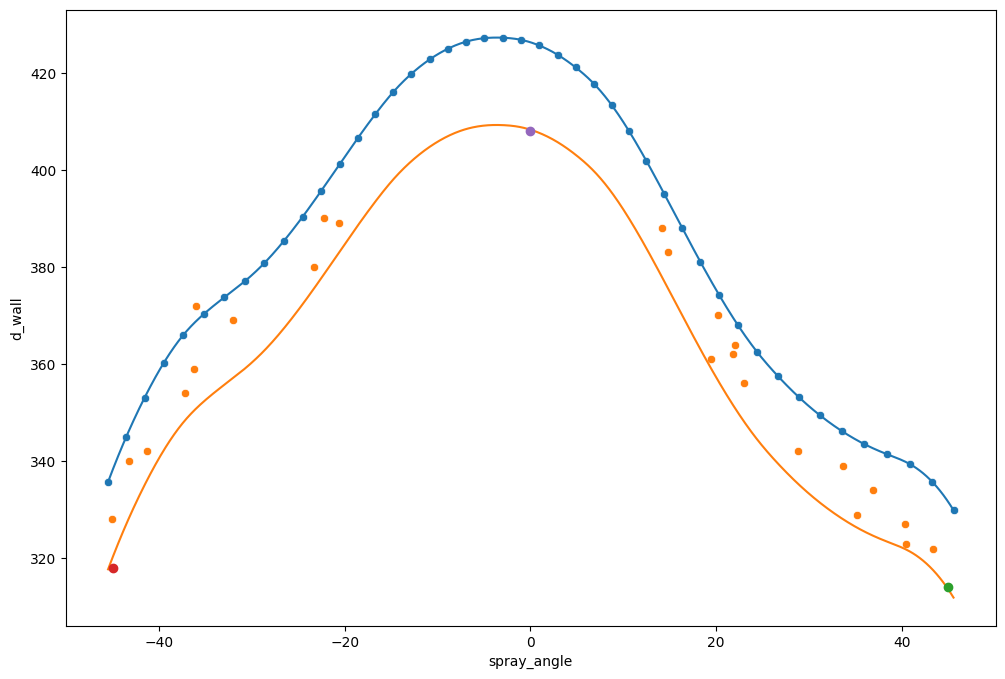

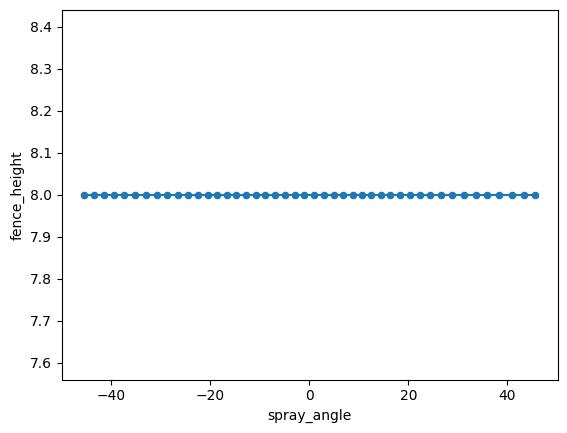

In [81]:
from scipy.interpolate import make_interp_spline

temp = outfield_dims.query('team_abv == "NYY"').sort_values('spray_angle')

x_hat = np.linspace(temp['spray_angle'].min(), temp['spray_angle'].max(),1000)

dist_func = make_interp_spline(temp['spray_angle'], temp['d_wall'])
height_func = make_interp_spline(temp['spray_angle'], temp['fence_height'],k=1)

plt.figure(figsize=(12,8))

sns.scatterplot(temp, x='spray_angle',y='d_wall')
sns.scatterplot(hits_data[(hits_data['class']=='Incorrect, Not Homer') & (hits_data['home_team']=='NYY')], x='spray_angle_true', y='hit_distance_sc')
plt.plot(x_hat, dist_func(x_hat))
plt.plot(x_hat, dist_func(x_hat)-18)
plt.plot(45, 314,'o')
plt.plot(-45, 318,'o')
plt.plot(0,408,'o')
plt.show()

sns.scatterplot(temp, x='spray_angle',y='fence_height')
plt.plot(x_hat, height_func(x_hat))
plt.show()

In [29]:
height_func(-13.904309)

array(37.)

In [380]:
def closest_point(row):
    """Finds the index of the closest point in a list of nodes to a given node.

    Args:
        node (numpy.ndarray): The coordinates of the reference node.
        nodes (list): A list of nodes represented as numpy arrays.

    Returns:
        int: The index of the closest node in the list.
    """
    node = np.asarray([row[0],row[1]])
    
    nodes = np.asarray(outfield_dims.query(f'team_abv == "{row[2]}"')[['x','y']])
    dist_2 = np.sum((nodes - node) ** 2, axis=1)

    return np.argmin(dist_2)

def get_height_at_closest_point(row):
    return outfield_dims.query(f'team_abv == "{row[1]}"').iloc[row[0],:]['fence_height']

hits_data['closest_point'] = hits_data[['hc_x_','hc_y_','home_team']].apply(lambda row: closest_point(row),1)

hits_data['fence_height'] = hits_data[['closest_point','home_team']].apply(lambda row: get_height_at_closest_point(row),axis=1)

array(8.)

In [322]:
outfield_dims.query('team_abv == "SF"').iloc[8,:]['fence_height']

25.0

In [317]:
hits_data.query('events == "Home Run"')[['home_team','hc_x_','hc_y_','closest_point']]

,home_team,hc_x_,hc_y_,closest_point
2,BOS,-99.801883,403.150693,31
3,SF,209.661321,343.179719,8
18,BAL,-132.944394,405.346884,30
29,CHC,-112.754416,395.189503,29
31,LAD,-32.019459,317.524221,24
...,...,...,...,...
15807,HOU,226.407273,323.414005,5
15827,HOU,191.742403,320.444156,6
15842,BAL,11.430173,458.280066,22
15844,MIA,-81.508615,407.068897,28


In [306]:
hits_data['closest_point']

0        31
1         1
2        31
3         8
4         8
         ..
15848    32
15849    24
15850    15
15851    16
15852    32
Name: closest_point, Length: 15853, dtype: int64

In [207]:
helpers.closest_point([238,279],outfield_dims.query('team == "cubs"')[['x','y']])

AttributeError: module 'utils.helpers' has no attribute 'closest_point'

In [190]:
outfield_dims.query('team == "cubs"').iloc[3,:][['d_wall','spray_angle']]

d_wall         362.102198
spray_angle      39.80139
Name: 301, dtype: object

In [85]:
import math

In [101]:
hits_data['test_angle'] = hits_data[['hc_x_','hc_y_']].apply(lambda x: (math.atan(x[0]/x[1])*180/math.pi*.75),1)

(-45.0, 45.0)

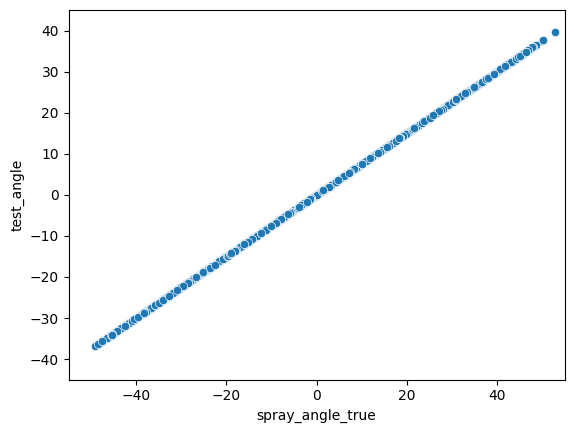

In [102]:
sns.scatterplot(data=hits_data, x='spray_angle_true',y='test_angle')
plt.xlim([-55,55])
plt.ylim([-45,45])

In [90]:
hits_data['test_angle'].max()

39.6

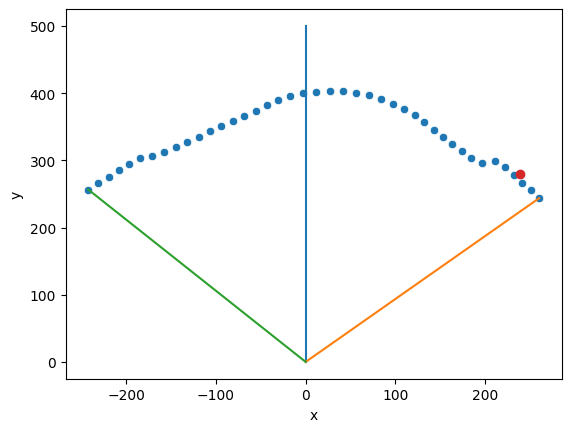

In [192]:
sns.scatterplot(data=outfield_dims.query('team == "cubs"'), x='x',y='y')
plt.plot([0,0],[0,500])
plt.plot([0,260.048918],[0,243.652360])
plt.plot([0,-242.274875	],[0,256.544719])
plt.plot(238.7,279.14,'o')

In [193]:
math.dist([0,0],[238.7,279.14])

367.2830374520446

In [156]:
hits_data['home_team'].unique()

array(['CHC', 'BOS', 'SF', 'SEA', 'HOU', 'KC', 'BAL', 'CIN', 'MIA', 'PHI',
       'CLE', 'MIN', 'MIL', 'NYM', 'LAD', 'STL', 'DET', 'WSH', 'CWS',
       'TOR', 'ATL', 'ARI', 'COL', 'TB', 'NYY', 'OAK', 'LAA', 'PIT', 'SD',
       'TEX'], dtype=object)

In [175]:
hits_data['spray_angle_true'] = hits_data.apply(lambda x: helpers.spray_angle(x.hc_x_, x.hc_y_),1)

In [194]:
hits_data.columns

Index(['player_name', 'game_date', 'game_type', 'player_team', 'events', 'des',
       'home_team', 'away_team', 'bb_type', 'outs_when_up', 'inning',
       'inning_topbot', 'plate_z', 'hc_x', 'hc_y', 'hit_distance_sc',
       'launch_angle', 'launch_speed', 'hc_x_', 'hc_y_', 'launch_angle_rads',
       'launch_speed_fts', 'launch_speed_x', 'launch_speed_y', 'spray_angle',
       'index', 'hit_direction', 'stadium_observed', 'logo_html', 'headshot',
       'spray_angle_true'],
      dtype='object')

In [202]:
hits_data.query('home_team == "CHC"')[['events','inning','hc_x_','hc_y_','hit_distance_sc','launch_angle','launch_speed_fts','launch_speed_x','launch_speed_y','spray_angle_true']]

,events,inning,hc_x_,hc_y_,hit_distance_sc,launch_angle,launch_speed_fts,launch_speed_x,launch_speed_y,spray_angle_true
0,Double,6.0,-104.468788,315.802208,331.0,16.0,154.586667,148.598241,42.609860,-18.304447
17,"In play, out(s)",4.0,153.059502,307.716234,339.0,34.0,140.946667,116.850082,78.816376,26.445968
29,Home Run,4.0,-112.754416,395.189503,408.0,27.0,147.840000,131.726405,67.117955,-15.924367
71,"In play, out(s)",9.0,75.394221,364.168312,368.0,30.0,148.720000,128.795298,74.360000,11.696770
72,Home Run,9.0,-105.691667,397.186040,408.0,29.0,155.906667,136.359043,75.585052,-14.901163
...,...,...,...,...,...,...,...,...,...,...
15750,Triple,3.0,238.735888,279.140801,359.0,25.0,145.346667,131.728816,61.426156,40.538801
15810,Double,2.0,-202.923009,281.636472,343.0,26.0,160.013333,143.819031,70.145228,-35.773276
15819,"In play, out(s)",9.0,66.484675,376.671624,379.0,28.0,152.386667,134.549441,71.541207,10.009929
15828,Double,9.0,-205.643290,293.440996,354.0,24.0,154.880000,141.489920,62.995371,-35.022751


In [125]:
outfield_dims['team'].unique()

array(['angels', 'astros', 'athletics', 'blue_jays', 'braves', 'brewers',
       'cardinals', 'cubs', 'diamondbacks', 'dodgers', 'giants',
       'indians', 'mariners', 'marlins', 'mets', 'nationals', 'orioles',
       'padres', 'phillies', 'pirates', 'rangers', 'rays', 'reds',
       'rockies', 'royals', 'tigers', 'twins', 'white_sox', 'yankees',
       'red_sox'], dtype=object)

In [126]:
outfield_dims.query('team == "cubs" and segment == "outfield_outer"')

,stadium,full_team_name,team,team_abbr,x,y,d_wall,segment,spray_angle_stadia,fence_height,orientation
298,Wrigley Field,Chicago Cubs,cubs,CHC,260.048918,243.652360,356.359246,outfield_outer,35.1,16.0,NE
299,Wrigley Field,Chicago Cubs,cubs,CHC,250.666382,255.195296,357.712558,outfield_outer,33.4,16.0,NE
300,Wrigley Field,Chicago Cubs,cubs,CHC,241.226180,266.691178,359.602912,outfield_outer,31.6,16.0,NE
301,Wrigley Field,Chicago Cubs,cubs,CHC,231.791876,278.191531,362.102198,outfield_outer,29.9,16.0,NE
302,Wrigley Field,Chicago Cubs,cubs,CHC,222.284561,289.630579,365.097656,outfield_outer,28.1,16.0,NE
303,Wrigley Field,Chicago Cubs,cubs,CHC,211.213896,298.557122,365.715278,outfield_outer,26.5,16.0,NE
304,Wrigley Field,Chicago Cubs,cubs,CHC,196.669380,296.084714,355.450423,outfield_outer,25.2,11.0,NE
305,Wrigley Field,Chicago Cubs,cubs,CHC,184.406558,303.466200,355.102116,outfield_outer,23.5,11.0,NE
306,Wrigley Field,Chicago Cubs,cubs,CHC,174.047724,314.139418,359.132544,outfield_outer,21.7,11.0,NE
307,Wrigley Field,Chicago Cubs,cubs,CHC,163.535396,324.662288,363.523626,outfield_outer,20.1,11.0,NE


<AxesSubplot: xlabel='x', ylabel='y'>

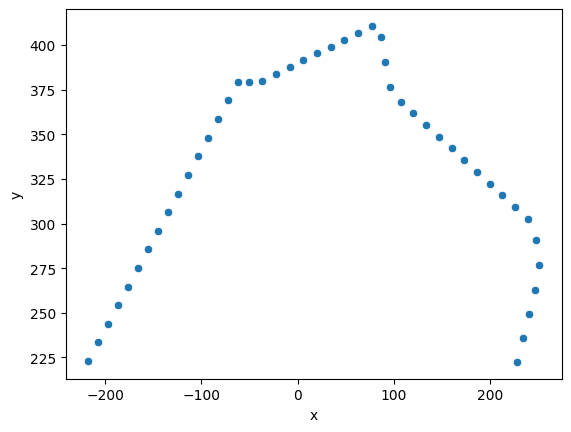

In [74]:
sns.scatterplot(data=outfield_dims.query('team == "red_sox" and segment == "outfield_outer"'), x='x',y='y')

In [69]:
dims.query('team == "angels" and segment == "outfield_outer"')

,team,x,y,segment,spray_angle
3029,angels,26.270000,104.810000,outfield_outer,-64.886743
3030,angels,25.932060,98.807795,outfield_outer,-58.195165
3031,angels,26.551758,92.865560,outfield_outer,-52.101109
3032,angels,29.069971,87.457350,outfield_outer,-46.118702
3033,angels,32.986155,82.913310,outfield_outer,-40.808629
...,...,...,...,...,...
3123,angels,36.234236,132.025786,outfield_outer,-113.153543
3124,angels,32.618710,127.222803,outfield_outer,-104.539903
3125,angels,29.003184,122.419820,outfield_outer,-97.791428
3126,angels,27.310342,116.780127,outfield_outer,-85.231652


In [4]:
hits_data['home_team'].unique()

array(['CHC', 'BOS', 'SF', 'SEA', 'HOU', 'KC', 'BAL', 'CIN', 'MIA', 'PHI',
       'CLE', 'MIN', 'MIL', 'NYM', 'LAD', 'STL', 'DET', 'WSH', 'CWS',
       'TOR', 'ATL', 'ARI', 'COL', 'TB', 'NYY', 'OAK', 'LAA', 'PIT', 'SD',
       'TEX'], dtype=object)

In [5]:
hits_data.query('home_team == "BOS" and events == "Home Run"')['spray_angle'].describe()

count    109.000000
mean      -5.919266
std       20.925425
min      -35.100000
25%      -24.100000
50%      -10.000000
75%       13.100000
max       36.400000
Name: spray_angle, dtype: float64

In [7]:
# Spray Angle conversion

dims['spray_angle'] =  np.tan((dims['x']-128)/(208-dims['y']))*180/np.pi*0.75

c:\Users\noahs\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in tan
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
dims['segment'].unique()

array(['infield_inner', 'infield_outer', 'outfield_outer',
       'outfield_inner', 'foul_lines', 'home_plate'], dtype=object)

In [9]:
dims.query('team == "red_sox" and (segment == "foul_lines" or segment == "foul_lines")')['y'].min()

112.68549910874

In [217]:
dims.query('team == "red_sox" and (segment == "foul_lines")').max()

team              red_sox
x              214.746905
y                  204.53
segment        foul_lines
spray_angle       57.6048
dtype: object

In [46]:
red_sox = dims.query('team == "red_sox" and (segment == "foul_lines" or segment == "outfield_outer")')

In [27]:
def find_peak(df):
    y_point = float(df['y'].max())
    x_point = float(df[df['y']==y_point]['x'])

    return x_point, y_point

In [53]:
def get_team_foul_lines(df, team):
    foul_lines_df = df.query(f"team == '{team}' & segment == 'foul_lines'")
    return foul_lines_df

def get_team_outfield(df, team):
    outfield_df = df.query(f"team == '{team}' & segment == 'outfield_outer'")
    return outfield_df

def get_only_outfield(df, team):
    foul_lines_df = get_team_foul_lines(df, team)
    outfield_df = get_team_outfield(df, team)

    only_outfield_df = outfield_df[outfield_df['y']<=foul_lines_df['y'].min()]

    return only_outfield_df

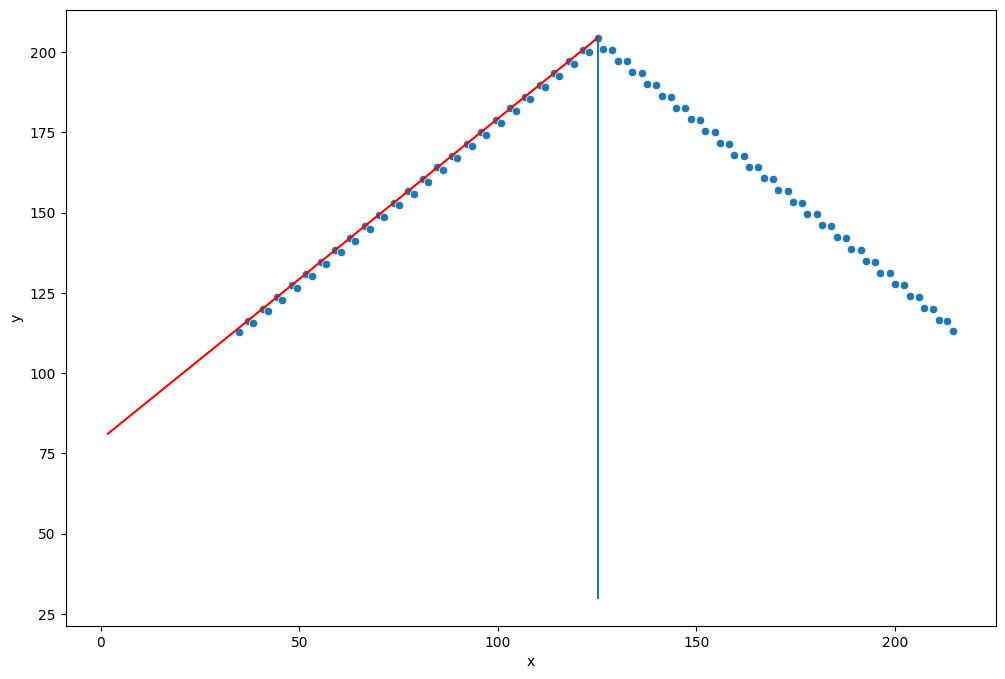

In [49]:
foul_lines_df = get_team_foul_lines(dims, "red_sox")

peak_x, peak_y = find_peak(foul_lines_df)

x = np.array([peak_x] * 1000)
y = np.linspace(30,peak_y, 1000)

d = np.deg2rad(-45)

x1 = (x - peak_x)*np.cos(d) - (y - peak_y)*np.sin(d) + peak_x
y1 = (x - peak_x)*np.sin(d) + (y - peak_y)*np.cos(d) + peak_y

plt.figure(figsize=(12,8))

sns.scatterplot(data=foul_lines_df, x='x',y='y')
plt.plot(x,y)
plt.plot(x1,y1,'r')

In [61]:
dims['team'].unique()

array(['angels', 'astros', 'athletics', 'blue_jays', 'braves', 'brewers',
       'cardinals', 'cubs', 'diamondbacks', 'dodgers', 'giants',
       'indians', 'mariners', 'marlins', 'mets', 'nationals', 'orioles',
       'padres', 'phillies', 'pirates', 'rangers', 'rays', 'red_sox',
       'reds', 'rockies', 'royals', 'tigers', 'twins', 'white_sox',
       'yankees', 'generic'], dtype=object)

C:\Users\noahs\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot: xlabel='x', ylabel='y'>

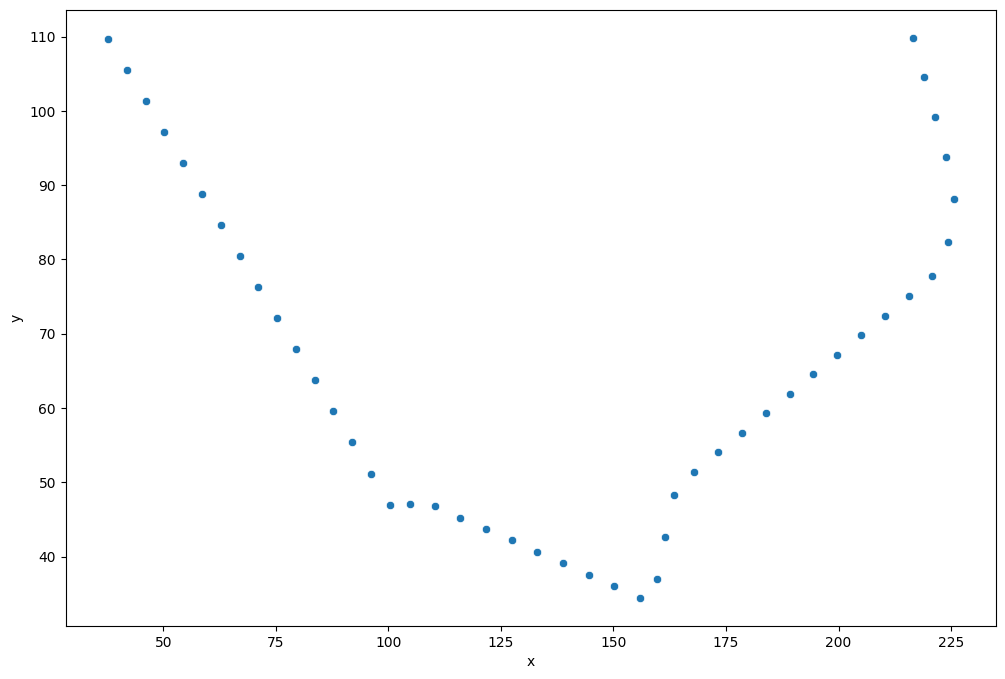

In [72]:
only_outfield_df = get_only_outfield(dims, "red_sox")

x_hat = np.linspace(only_outfield_df['x'].min(), only_outfield_df['x'].max(), 1000)

plt.figure(figsize=(12,8))

# my_pwlf = pwlf.PiecewiseLinFit(only_outfield_df['x'], only_outfield_df['y'])
# breaks = my_pwlf.fit(6)

# y_hat = my_pwlf.predict(x_hat)

model = np.polyfit(only_outfield_df['x'], only_outfield_df['y'], 20)
func = np.poly1d(model)

y_hat = func(x_hat)

sns.scatterplot(data=only_outfield_df, x='x',y='y')
#plt.plot(x_hat, y_hat,'r')

In [ ]:
df['spray_angle'] = np.tan((df['hc_x']-128)/(208-df['hc_y']))*180/np.pi*0.75

In [118]:
dist = np.polyfit(df['spray_angle_stadia'], df['d_wall'], 20)
f_dist = np.poly1d(dist)

height = np.polyfit(df['spray_angle_stadia'], df['fence_height'], 20)
f_height = np.poly1d(height)

x1 = np.linspace(min(df['spray_angle_stadia']), max(df['spray_angle_stadia']), 1000)
y1 = f_dist(x1)
y2 = f_height(x1)

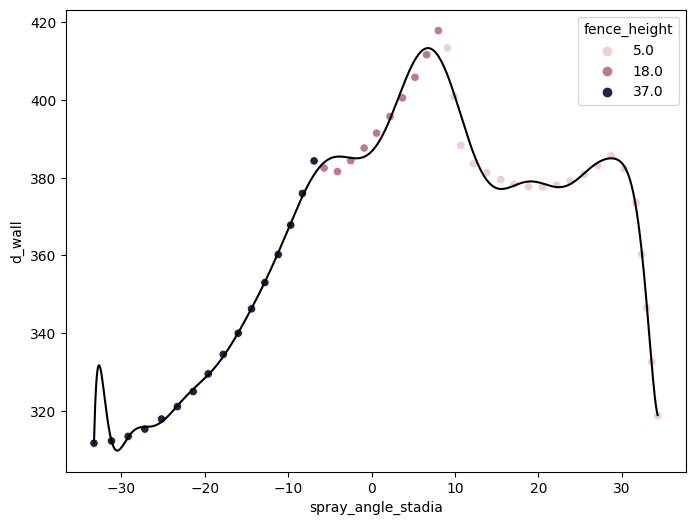

In [119]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=df, x='spray_angle_stadia',y='d_wall',hue='fence_height')

plt.plot(x1, y1, c='black')

In [106]:
from scipy import optimize

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(0, 15, 100)
plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p))

NameError: name 'x' is not defined

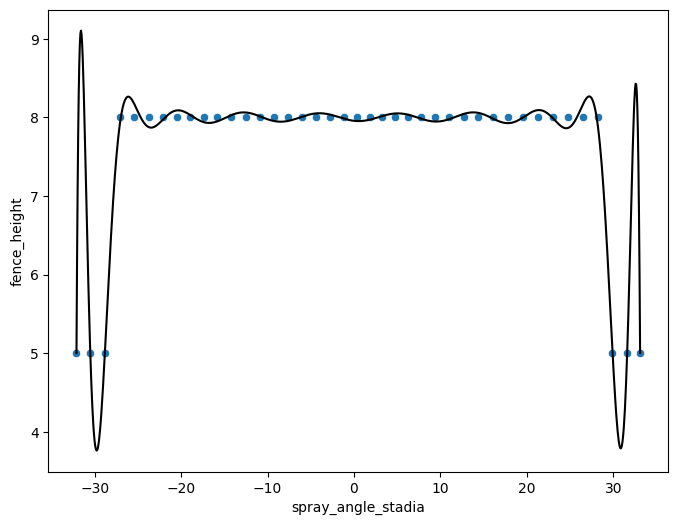

In [105]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=angels, x='spray_angle_stadia',y='fence_height')

plt.plot(x1, y2, c='black')

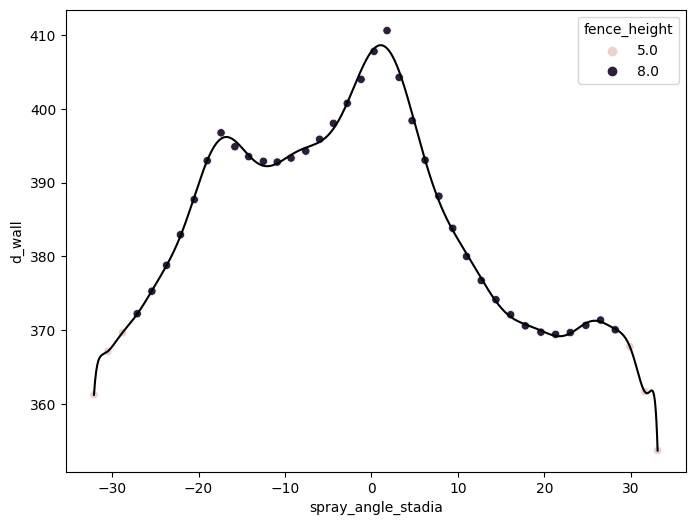

In [74]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=angels, x='spray_angle_stadia',y='d_wall',hue='fence_height')

plt.plot(x1, y1, c='black')

<AxesSubplot: xlabel='spray_angle_stadia', ylabel='d_wall'>

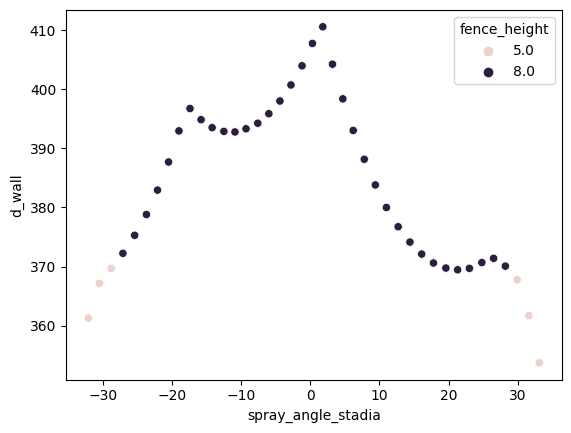

In [38]:
sns.scatterplot(data=angels,x='spray_angle_stadia',y='d_wall',hue='fence_height')

<AxesSubplot: xlabel='x', ylabel='y'>

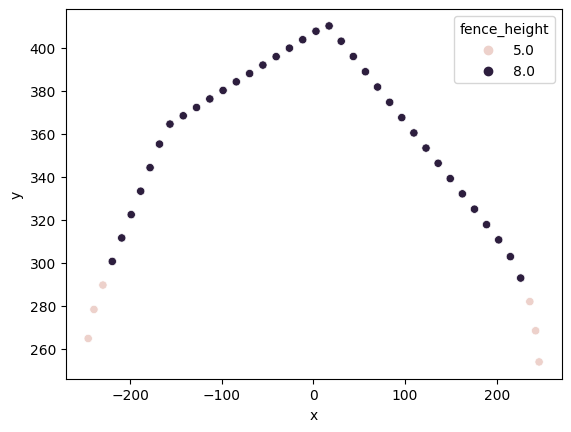

In [31]:
sns.scatterplot(data=angels,x='x',y='y',hue='fence_height')

In [36]:
def parametric_curve(x1, y1, x2, y2):
    xslope = x2 - x1
    yslope = y2 - y1
    tt = np.linspace(0, 1, num=100)
    ll = [pd.DataFrame({"x": x1 + xslope * s, "y": y1 + yslope * s}) for s in tt]
    return pd.concat(ll)

def geom_curve_gen_points(x1, x2, y, curvature):
    if x2 < x1:
        tmp = x1
        x1 = x2
        x2 = tmp
    
    k = curvature
    xscale = 0.5 * (x2 - x1)

    d1 = (1 - k**2) / (2 * k)
    r = d1 + k

    starting_theta = abs(np.arctan2(1, d1))
    tt = np.linspace(-starting_theta, starting_theta, num=100)
    x0 = 0.5 * (x1 + x2)
    y0 = y + d1 * xscale
    r = r * xscale
    xx = x0 + r * np.sin(tt)
    yy = y0 - r * np.cos(tt)
    return pd.DataFrame({"t": tt, "x": xx, "y": yy})



def generate_sample_data():
    np.random.seed(101)
    batted_ball_data = pd.DataFrame(
        {"hc_x": np.random.normal(125, 10, 20), "hc_y": np.random.normal(100, 20, 20)}
    )
    batted_ball_data["team"] = np.repeat(["angels", "yankees"], 10)
    return batted_ball_data


def generic_ballpark():
    left_outfield_line = parametric_curve(125, 208, 30, 100)
    outfield_curve = geom_curve_gen_points(30, 220, 100, 0.9)[:, ["x", "y"]]
    right_outfield_line = parametric_curve(220, 100, 125, 208)

    left_infield_line = parametric_curve(125, 208, 80, 155)
    infield_curve = geom_curve_gen_points(80, 170, 155, 0.9)[:, ["x", "y"]]
    right_infield_line = parametric_curve(170, 155, 125, 208)

    outfield_path = pd.concat(
        [left_outfield_line, outfield_curve, right_outfield_line], axis=0
    )
    outfield_path["segment"] = "outfield_outer"
    infield_path = pd.concat(
        [left_infield_line, infield_curve, right_infield_line], axis=0
    )
    infield_path["segment"] = "infield_outer"

    path_df = pd.concat([outfield_path, infield_path], axis=0)
    team_df = pd.DataFrame({"team": ["generic"] * len(path_df)})
    return pd.concat([team_df, path_df], axis=1)

